In [2]:
import sys
sys.path.append('/kaggle/input/amp-pd')

In [3]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()
iter_test = env.iter_test()

In [4]:
counter = 0
# The API will deliver four dataframes in this specific order:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    if counter == 0:
        print(test.head())
        print(test_peptides.head())
        print(test_proteins.head())
        print(sample_submission.head())
        sample_submission['rating'] = 0
    env.predict(sample_submission)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
  visit_id  visit_month  patient_id updrs_test           row_id
0   3342_0            0        3342    updrs_1   3342_0_updrs_1
1   3342_0            0        3342    updrs_2   3342_0_updrs_2
2   3342_0            0        3342    updrs_3   3342_0_updrs_3
3   3342_0            0        3342    updrs_4   3342_0_updrs_4
4  50423_0            0       50423    updrs_1  50423_0_updrs_1
  visit_id  visit_month  patient_id UniProt  \
0  50423_0            0       50423  O00391   
1  50423_0            0       50423  O00391   
2  50423_0            0       50423  O00533   
3  50423_0            0       50423  O00533   
4  50423_0            0       50423  O00533   

                                  Peptide  PeptideAbundance  
0                    AHFSPSNIILDFPAAGSAAR           22226.3  
1                           NEQEQPLGQWHLS           10901.6  
2                     

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-pd/train_proteins.csv
/kaggle/input/amp-pd/train_clinical_data.csv
/kaggle/input/amp-pd/public_timeseries_testing_util.py
/kaggle/input/amp-pd/supplemental_clinical_data.csv
/kaggle/input/amp-pd/train_peptides.csv
/kaggle/input/amp-pd/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-pd/amp_pd_peptide/__init__.py
/kaggle/input/amp-pd/amp_pd_peptide_310/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/amp-pd/amp_pd_peptide_310/__init__.py
/kaggle/input/amp-pd/example_test_files/sample_submission.csv
/kaggle/input/amp-pd/example_test_files/test_proteins.csv
/kaggle/input/amp-pd/example_test_files/test_peptides.csv
/kaggle/input/amp-pd/example_test_files/test.csv


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
from pathlib import Path
from sklearn.decomposition import PCA
from keras.layers import Input, Dense, concatenate
from keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf
from keras.losses import mean_absolute_percentage_error
import tensorflow as tf
warnings.filterwarnings('ignore')  
%matplotlib inline

In [7]:
train_clinical_df = pd.read_csv('/kaggle/input/amp-pd/train_clinical_data.csv') 
train_peptide_df = pd.read_csv('/kaggle/input/amp-pd/train_peptides.csv')
train_protein_df = pd.read_csv('/kaggle/input/amp-pd/train_proteins.csv') 
supp_df = pd.read_csv('/kaggle/input/amp-pd/supplemental_clinical_data.csv')

In [8]:
train_peptide_df

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.30
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.00
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.00
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...,...
981829,58648_108,108,58648,Q9UHG2,ILAGSADSEGVAAPR,202820.00
981830,58648_108,108,58648,Q9UKV8,SGNIPAGTTVDTK,105830.00
981831,58648_108,108,58648,Q9Y646,LALLVDTVGPR,21257.60
981832,58648_108,108,58648,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [9]:
train_clinical_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
2610,65043_48,65043,48,7.0,6.0,13.0,0.0,Off
2611,65043_54,65043,54,4.0,8.0,11.0,1.0,Off
2612,65043_60,65043,60,6.0,6.0,16.0,1.0,Off
2613,65043_72,65043,72,3.0,9.0,14.0,1.0,Off


In [10]:
supp_df.drop(supp_df.columns[-1], axis=1, inplace = True)
train_clinical_df.drop(train_clinical_df.columns[-1],axis=1,inplace = True)

supp_df.fillna(supp_df.mean(), inplace=True)

supp_df.shape, train_clinical_df.shape

((2223, 7), (2615, 7))

In [11]:
supp_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,35_0,35,0,5.00000,3.000000,16.0,0.000000
1,35_36,35,36,6.00000,4.000000,20.0,0.000000
2,75_0,75,0,4.00000,6.000000,26.0,0.000000
3,75_36,75,36,1.00000,8.000000,38.0,0.000000
4,155_0,155,0,5.68408,6.507715,0.0,0.840154
...,...,...,...,...,...,...,...
2218,65382_0,65382,0,5.68408,6.507715,0.0,0.840154
2219,65405_0,65405,0,5.00000,16.000000,31.0,0.000000
2220,65405_5,65405,5,5.68408,6.507715,57.0,0.840154
2221,65530_0,65530,0,10.00000,6.000000,24.0,0.000000


In [12]:
# concatenate the two train_clinical_df and supp_df vertically
train_df = pd.concat([train_clinical_df, supp_df], ignore_index=True)
train_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.00000,6.000000,15.0,NaN
1,55_3,55,3,10.00000,7.000000,25.0,NaN
2,55_6,55,6,8.00000,10.000000,34.0,NaN
3,55_9,55,9,8.00000,9.000000,30.0,0.000000
4,55_12,55,12,10.00000,10.000000,41.0,0.000000
...,...,...,...,...,...,...,...
4833,65382_0,65382,0,5.68408,6.507715,0.0,0.840154
4834,65405_0,65405,0,5.00000,16.000000,31.0,0.000000
4835,65405_5,65405,5,5.68408,6.507715,57.0,0.840154
4836,65530_0,65530,0,10.00000,6.000000,24.0,0.000000


In [13]:
# assume df is your DataFrame
cols_to_normalize = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']
# Apply log(1+x) transformation to the last 4 columns
train_df[cols_to_normalize] = np.log1p(train_df[cols_to_normalize])
train_df

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,2.397895,1.945910,2.772589,NaN
1,55_3,55,3,2.397895,2.079442,3.258097,NaN
2,55_6,55,6,2.197225,2.397895,3.555348,NaN
3,55_9,55,9,2.197225,2.302585,3.433987,0.000000
4,55_12,55,12,2.397895,2.397895,3.737670,0.000000
...,...,...,...,...,...,...,...
4833,65382_0,65382,0,1.899729,2.015931,0.000000,0.609850
4834,65405_0,65405,0,1.791759,2.833213,3.465736,0.000000
4835,65405_5,65405,5,1.899729,2.015931,4.060443,0.609850
4836,65530_0,65530,0,2.397895,1.945910,3.218876,0.000000


In [14]:
from sklearn.impute import SimpleImputer

# perform mean imputation on the normalized data
imputer = SimpleImputer(strategy='mean')
# Impute missing values in the last 4 columns
train_df[cols_to_normalize] = np.maximum(imputer.fit_transform(train_df[cols_to_normalize]), 0)
train_df[cols_to_normalize] = np.maximum(np.expm1(train_df[cols_to_normalize]), 0)
train_df 

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
0,55_0,55,0,10.00000,6.000000,15.0,0.688385
1,55_3,55,3,10.00000,7.000000,25.0,0.688385
2,55_6,55,6,8.00000,10.000000,34.0,0.688385
3,55_9,55,9,8.00000,9.000000,30.0,0.000000
4,55_12,55,12,10.00000,10.000000,41.0,0.000000
...,...,...,...,...,...,...,...
4833,65382_0,65382,0,5.68408,6.507715,0.0,0.840154
4834,65405_0,65405,0,5.00000,16.000000,31.0,0.000000
4835,65405_5,65405,5,5.68408,6.507715,57.0,0.840154
4836,65530_0,65530,0,10.00000,6.000000,24.0,0.000000


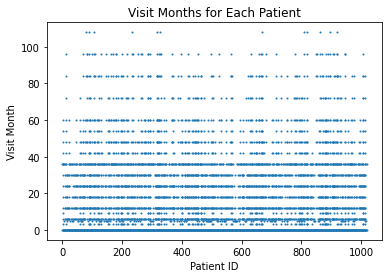

In [15]:
# create a new column with a unique identifier for each patient
df = train_df.copy(deep=True)
df['patient_index'] = df.groupby('patient_id').ngroup()

# create a scatter plot for patient_index versus visit_month
plt.scatter(df['patient_index'], df['visit_month'], s=1)

#plt.scatter(df_new_index.index, df_new_index["visit_month"], s=1)
plt.xlabel("Patient ID")
plt.ylabel("Visit Month")
plt.title("Visit Months for Each Patient")

# display the plot
plt.show()

In [16]:
train_df = train_df.rename(columns={
    'updrs_1': 'updrs_1_plus_0_months',
    'updrs_2': 'updrs_2_plus_0_months',
    'updrs_3': 'updrs_3_plus_0_months',
    'updrs_4': 'updrs_4_plus_0_months'
})
train_df

,visit_id,patient_id,visit_month,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months
0,55_0,55,0,10.00000,6.000000,15.0,0.688385
1,55_3,55,3,10.00000,7.000000,25.0,0.688385
2,55_6,55,6,8.00000,10.000000,34.0,0.688385
3,55_9,55,9,8.00000,9.000000,30.0,0.000000
4,55_12,55,12,10.00000,10.000000,41.0,0.000000
...,...,...,...,...,...,...,...
4833,65382_0,65382,0,5.68408,6.507715,0.0,0.840154
4834,65405_0,65405,0,5.00000,16.000000,31.0,0.000000
4835,65405_5,65405,5,5.68408,6.507715,57.0,0.840154
4836,65530_0,65530,0,10.00000,6.000000,24.0,0.000000


In [17]:
# define an empty DataFrame with column names
ts_df_updrs = pd.DataFrame(columns=['time', 'patient_id',  'visit_id',
                                    'updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                                    'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                                    'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                                    'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months'
                                    ])

In [18]:
for patient_id in train_df['patient_id'].unique():
    # filter a subset of visiting records for a selected patient_id 
    p_df = train_df[train_df['patient_id']==patient_id]
    ts_start = p_df.visit_month.min()
    ts_end = p_df.visit_month.max()
    ts_span = ts_end - ts_start
    p_num = p_df.shape[0]
    if (p_num > 1) and (ts_span >= 30) and (ts_span/(p_df.shape[0]-1) < 24):
        # the last visit record is 72
        if ts_end > 72:
            ts_end = 72+1

        patient_df = pd.DataFrame({'time': range(ts_start, ts_end, 6), 'patient_id': patient_id})
        # Add the visit_id column
        patient_df['visit_id'] = patient_df['patient_id'].astype(str) + '_' + patient_df['time'].astype(str)
        # merge dataframes on visit_id using left join
        merged_df = pd.merge(patient_df, p_df, on='visit_id', how='left')
        merged_df.drop('patient_id_y', axis=1,inplace = True)
        merged_df.rename(columns={'patient_id_x': 'patient_id'},inplace = True)
        # forward fill missing values
        merged_df = merged_df.fillna(method='ffill')
        # generate new columns updrs_p6_1, updrs_p6_2, updrs_p6_3, updrs_p6_4
        merged_df['updrs_1_plus_6_months'] = merged_df['updrs_1_plus_0_months'].shift(-1)
        merged_df['updrs_2_plus_6_months'] = merged_df['updrs_2_plus_0_months'].shift(-1)
        merged_df['updrs_3_plus_6_months'] = merged_df['updrs_3_plus_0_months'].shift(-1)
        merged_df['updrs_4_plus_6_months'] = merged_df['updrs_4_plus_0_months'].shift(-1)
        merged_df['updrs_1_plus_12_months'] = merged_df['updrs_1_plus_0_months'].shift(-2)
        merged_df['updrs_2_plus_12_months'] = merged_df['updrs_2_plus_0_months'].shift(-2)
        merged_df['updrs_3_plus_12_months'] = merged_df['updrs_3_plus_0_months'].shift(-2)
        merged_df['updrs_4_plus_12_months'] = merged_df['updrs_4_plus_0_months'].shift(-2)
        merged_df['updrs_1_plus_24_months'] = merged_df['updrs_1_plus_0_months'].shift(-4)
        merged_df['updrs_2_plus_24_months'] = merged_df['updrs_2_plus_0_months'].shift(-4)
        merged_df['updrs_3_plus_24_months'] = merged_df['updrs_3_plus_0_months'].shift(-4)
        merged_df['updrs_4_plus_24_months'] = merged_df['updrs_4_plus_0_months'].shift(-4)
        merged_df = merged_df.drop('visit_month', axis=1)
        merged_df = merged_df.dropna()
        ts_df_updrs= pd.concat([ts_df_updrs, merged_df],ignore_index=True)

In [19]:
 ts_df_updrs

,time,patient_id,visit_id,updrs_1_plus_0_months,updrs_2_plus_0_months,updrs_3_plus_0_months,updrs_4_plus_0_months,updrs_1_plus_6_months,updrs_2_plus_6_months,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,0,55,55_0,10.0,6.0,15.0,0.688385,8.0,10.0,34.0,0.688385,10.0,10.0,41.0,0.000000,16.0,9.0,49.0,0.000000
1,6,55,55_6,8.0,10.0,34.0,0.688385,10.0,10.0,41.0,0.000000,7.0,13.0,38.0,0.000000,14.0,13.0,49.0,0.000000
2,12,55,55_12,10.0,10.0,41.0,0.000000,7.0,13.0,38.0,0.000000,16.0,9.0,49.0,0.000000,17.0,18.0,51.0,0.000000
3,18,55,55_18,7.0,13.0,38.0,0.000000,16.0,9.0,49.0,0.000000,14.0,13.0,49.0,0.000000,12.0,20.0,41.0,0.000000
4,24,55,55_24,16.0,9.0,49.0,0.000000,14.0,13.0,49.0,0.000000,17.0,18.0,51.0,0.000000,17.0,16.0,52.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,0,64310,64310_0,4.0,3.0,22.0,0.840154,1.0,4.0,15.0,0.840154,2.0,4.0,13.0,0.840154,5.0,5.0,24.0,0.000000
1822,0,64685,64685_0,1.0,4.0,9.0,0.840154,1.0,2.0,11.0,0.840154,1.0,3.0,5.0,0.840154,3.0,7.0,24.0,0.840154
1823,0,64721,64721_0,2.0,7.0,54.0,0.840154,1.0,6.0,51.0,0.840154,1.0,6.0,47.0,0.000000,2.0,4.0,52.0,2.000000
1824,0,64938,64938_0,4.0,5.0,16.0,0.840154,1.0,5.0,20.0,0.000000,2.0,7.0,21.0,0.000000,7.0,7.0,21.0,0.000000


In [20]:
Prot_Peptides_df = pd.merge(train_protein_df, train_peptide_df, on = ['visit_id','UniProt'], how = 'left')
Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','NPX','Peptide','PeptideAbundance']]
Prot_Peptides_df

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
0,55_0,O00391,11254.3,NEQEQPLGQWHLS,11254.30
1,55_0,O00533,732430.0,GNPEPTFSWTK,102060.00
2,55_0,O00533,732430.0,IEIPSSVQQVPTIIK,174185.00
3,55_0,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.90
4,55_0,O00533,732430.0,SMEQNGPGLEYR,30838.70
...,...,...,...,...,...
981829,58648_108,Q9UHG2,369437.0,ILAGSADSEGVAAPR,202820.00
981830,58648_108,Q9UKV8,105830.0,SGNIPAGTTVDTK,105830.00
981831,58648_108,Q9Y646,21257.6,LALLVDTVGPR,21257.60
981832,58648_108,Q9Y6R7,17953.1,AGC(UniMod_4)VAESTAVC(UniMod_4)R,5127.26


In [21]:
# group by visit_id and get the set of unique UniProt values for each group
grouped = Prot_Peptides_df.groupby('visit_id')['UniProt'].apply(set)

# calculate the intersection of UniProt values across all groups
intersection = set.intersection(*grouped)

# print the intersection
print(intersection, len(intersection))

{'P01834', 'P02768', 'P02647', 'Q92520', 'P02790', 'P06396', 'P07602', 'P02751', 'P02774', 'P01009', 'P01011', 'P01876', 'P01024', 'P02765', 'P02787', 'P02749', 'O15240', 'Q9UHG2', 'P05090', 'P02649', 'P01023', 'P01042', 'P10909', 'Q12805', 'P41222', 'P23142', 'P02766'} 27


In [22]:
# set of UniProt values to select
uniprots_to_select = intersection

# filter the dataframe to select rows with UniProt values in the set
df_filtered = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select)]
# print the resulting dataframe
df_filtered

,visit_id,UniProt,NPX,Peptide,PeptideAbundance
15,55_0,O15240,177775.0,AYQGVAAPFPK,107076.00
16,55_0,O15240,177775.0,QQETAAAETETR,3095.35
17,55_0,O15240,177775.0,THLGEALAPLSK,67603.70
94,55_0,P01009,14415900.0,FLENEDR,41501.10
95,55_0,P01009,14415900.0,FLENEDRR,46973.10
...,...,...,...,...,...
981797,58648_108,Q92520,907400.0,SPFEQHIK,66357.20
981826,58648_108,Q9UHG2,369437.0,AEAQEAEDQQAR,7884.17
981827,58648_108,Q9UHG2,369437.0,ARAEAQEAEDQQAR,80542.00
981828,58648_108,Q9UHG2,369437.0,GEAAGAVQELAR,78191.40


In [23]:
# apply log(x+1) transformation to columns
df_filtered[['PeptideAbundance']] = df_filtered[['PeptideAbundance']].apply(lambda x: np.log1p(x))

# standardization
scaler1 = StandardScaler()
df_filtered[['PeptideAbundance']] = scaler1.fit_transform(df_filtered[['PeptideAbundance']])

In [24]:
# create a list of all peptides in the original data
all_peptides = df_filtered['Peptide'].unique()
all_visit_id = df_filtered['visit_id'].unique()

pca = PCA(n_components = 10)

# initialize an empty list to store the PCA features
pca_features_list = []

for visit_id in all_visit_id:
    # Part 1: construct UniProt-Peptide Network for each visit_id
    p_df = df_filtered[df_filtered['visit_id'] == visit_id]
    # first, pivot the data so that the UniProt column becomes the index, 
    # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
    pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
    # iterate over each UniProt and add missing peptides as columns with a value of 0
    for prot in pivoted.index:
        missing_peptides = set(all_peptides) - set(pivoted.columns)
        for pep in missing_peptides:
            pivoted.loc[prot, pep] = 0
            
    # fill any remaining missing values with 0
    pivoted.fillna(0, inplace=True)
    # reset the index so that UniProt is a column again
    pivoted = pivoted.reset_index()
    # rename the index column to 'UniProt'
    pivoted.index.name = 'UniProt'
    # save the pivoted DataFrame to a new variable called `new_df`
    new_df = pivoted.copy(deep=True)
    
    # Part II: PCA feature extraction
    # fit and transform the data
    df1_pca = pca.fit_transform(new_df.iloc[:,1:])
    # flatten the array to one dimension
    df1_pca = np.array(df1_pca).flatten()
    # store the PCA features along with the visit_id in the list
    pca_features_list.append({'visit_id': visit_id, 'pca_features': df1_pca})
    
# construct a dataframe from the PCA features list
df_pca_features = pd.DataFrame(pca_features_list)
# split the pca_features column into multiple columns
PP_features = pd.concat([df_pca_features.drop('pca_features', axis=1), df_pca_features['pca_features'].apply(pd.Series)], axis=1)

# display the resulting dataframe
print(PP_features)

       visit_id         0         1         2         3         4         5  \
0          55_0 -0.408761 -0.191259 -0.143086 -0.097637 -0.121823 -0.008657   
1        1517_0 -0.390323 -0.207683 -0.223584 -0.037062 -0.226242 -0.162619   
2        1923_0 -0.375939 -0.189745 -0.240332 -0.183197 -0.170522 -0.098476   
3        2660_0 -0.348659 -0.177171 -0.200724 -0.074223 -0.092662 -0.088853   
4        3636_0 -0.366450 -0.188364 -0.165799 -0.269625 -0.250694 -0.115397   
...         ...       ...       ...       ...       ...       ...       ...   
1108   58648_96 -0.375338 -0.090774 -0.171280 -0.221629 -0.094996 -0.008812   
1109   5645_108 -0.420115 -0.094926 -0.274239 -0.107466 -0.152648 -0.184514   
1110  12703_108 -0.335764 -0.160216 -0.159047 -0.013911 -0.230621 -0.141327   
1111  55096_108 -0.414612 -0.076189 -0.264506 -0.266721 -0.201371 -0.251426   
1112  58648_108 -0.371630 -0.114047 -0.246301 -0.108698 -0.044771 -0.252302   

             6         7         8  ...       260  

In [25]:
# Featureset = Protein-Peptide network informaion 
PP_features1 = pd.concat([PP_features, ts_df_updrs], axis=1, join='inner')
train_fea_target = PP_features1.dropna()
train_fea_target = train_fea_target.drop(columns=['visit_id','time', 'patient_id'])
train_fea_target

,0,1,2,3,4,5,6,7,8,9,...,updrs_3_plus_6_months,updrs_4_plus_6_months,updrs_1_plus_12_months,updrs_2_plus_12_months,updrs_3_plus_12_months,updrs_4_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_24_months,updrs_3_plus_24_months,updrs_4_plus_24_months
0,-0.408761,-0.191259,-0.143086,-0.097637,-0.121823,-0.008657,0.000184,0.053236,-0.344581,-0.109920,...,34.0,0.688385,10.0,10.0,41.0,0.0,16.0,9.0,49.0,0.0
1,-0.390323,-0.207683,-0.223584,-0.037062,-0.226242,-0.162619,-0.154679,-0.198600,-0.287681,-0.162002,...,41.0,0.000000,7.0,13.0,38.0,0.0,14.0,13.0,49.0,0.0
2,-0.375939,-0.189745,-0.240332,-0.183197,-0.170522,-0.098476,-0.070053,0.059326,-0.333420,-0.049260,...,38.0,0.000000,16.0,9.0,49.0,0.0,17.0,18.0,51.0,0.0
3,-0.348659,-0.177171,-0.200724,-0.074223,-0.092662,-0.088853,-0.301277,-0.341720,-0.287187,-0.303343,...,49.0,0.000000,14.0,13.0,49.0,0.0,12.0,20.0,41.0,0.0
4,-0.366450,-0.188364,-0.165799,-0.269625,-0.250694,-0.115397,-0.031362,-0.209024,-0.080025,-0.645917,...,49.0,0.000000,17.0,18.0,51.0,0.0,17.0,16.0,52.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,-0.375338,-0.090774,-0.171280,-0.221629,-0.094996,-0.008812,-0.347508,-0.134669,-0.286876,-0.242433,...,28.0,0.000000,12.0,22.0,35.0,0.0,13.0,17.0,31.0,3.0
1109,-0.420115,-0.094926,-0.274239,-0.107466,-0.152648,-0.184514,-0.073119,-0.387532,-0.517021,-0.449803,...,35.0,0.000000,12.0,18.0,36.0,0.0,14.0,15.0,27.0,3.0
1110,-0.335764,-0.160216,-0.159047,-0.013911,-0.230621,-0.141327,-0.093338,-0.162831,-0.246867,-0.144661,...,36.0,0.000000,13.0,17.0,31.0,3.0,16.0,13.0,30.0,5.0
1111,-0.414612,-0.076189,-0.264506,-0.266721,-0.201371,-0.251426,-0.266453,-0.234944,-0.409002,-0.118432,...,31.0,3.000000,14.0,15.0,27.0,3.0,16.0,13.0,30.0,5.0


In [26]:
target_list = PP_features1.columns[-16:]
cols_to_scale = train_fea_target.columns[:-16]

# perform z-score normalization on the training data
scaler_features = StandardScaler()
# fit and transform the data
scaler_features.fit(train_fea_target[cols_to_scale])
#train_fea_target[cols_to_scale] = scaler.transform(train_fea_target[cols_to_scale])
train_fea_target[cols_to_scale] = scaler_features.transform(train_fea_target[cols_to_scale])

In [27]:
# Split the data into training and testing sets (80% training, 20% testing)
train_df, test_df = train_test_split(train_fea_target , test_size=0.05, random_state=42)
# Split the training data into training and validation sets (90% training, 10% validation)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# Print the number of rows in each set
print(f'Training set: {len(train_df)} rows')
print(f'Validation set: {len(val_df)} rows')
print(f'Testing set: {len(test_df)} rows')

Training set: 951 rows
Validation set: 106 rows
Testing set: 56 rows


In [28]:
from tensorflow.keras.optimizers import Adam
X_train = train_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_train = train_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_val = val_df.iloc[:, :-16].astype(float)  # select all columns except the last 16
y_val = val_df.iloc[:, -16:].astype(float)   # select only the last 16 columns
X_test = test_df.iloc[:, :-16].astype(float)   # select all columns except the last 16
y_test = test_df.iloc[:, -16:].astype(float)  # select only the last 16 columns

In [29]:
def smape_loss(y_true, y_pred):
    y_true = K.cast(y_true,dtype='float32') + 1
    y_pred = y_pred + 1
    numer = K.abs(y_pred - y_true)
    denom = K.abs(y_true) + K.abs(y_pred) 
    smape = 100 * numer / denom
    return smape

In [30]:
def smape(y_true, y_pred):

    y_true = y_true +1
    y_pred = y_pred +1
    numerator = np.abs(y_pred - y_true)
    denominator = np.abs(y_pred) + np.abs(y_true) 
    
    smape = 100 * np.mean(numerator / denominator)
    return smape

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [32]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='linear'))
optimizer = Adam(lr=0.001)

In [33]:
model.compile(loss=smape_loss, optimizer='adam')
# fit model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 10, verbose=0, batch_size=32)

In [34]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

32.733150482177734


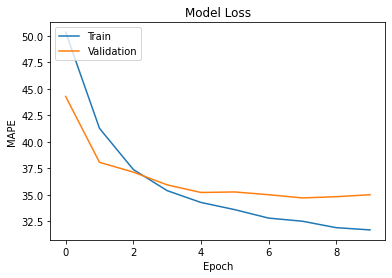

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Submission part

In [44]:
import pickle
# save scaler1 to a file using pickle
with open('scaler1.pkl', 'wb') as f:
    pickle.dump(scaler1, f)

with open('scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler_features, f)

In [45]:
import amp_pd_peptide
import pickle
amp_pd_peptide.make_env.func_dict['__called__'] = False
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
target_list_sub = ['updrs_1_plus_0_months','updrs_2_plus_0_months','updrs_3_plus_0_months', 'updrs_4_plus_0_months',
                   'updrs_1_plus_6_months','updrs_2_plus_6_months','updrs_3_plus_6_months', 'updrs_4_plus_6_months',
                   'updrs_1_plus_12_months','updrs_2_plus_12_months','updrs_3_plus_12_months', 'updrs_4_plus_12_months',
                   'updrs_1_plus_24_months','updrs_2_plus_24_months','updrs_3_plus_24_months', 'updrs_4_plus_24_months']

In [46]:
# load scaler1 from file using pickle
with open('scaler1.pkl', 'rb') as f:
    scaler1 = pickle.load(f)
with open('scaler_features.pkl', 'rb') as f:
    scaler_features = pickle.load(f)
    
uniprots_to_select2 = ['Q9UHG2', 'P05090', 'P41222', 'P02751', 'P01023', 'P02766',
                      'P01834', 'P02768', 'P02787', 'P02790', 'P01011', 'P02749', 
                      'P02774', 'P02765', 'P01042', 'P01024', 'P10909', 'P02649', 
                      'P07602', 'P02647', 'P01876', 'P06396', 'Q92520', 'P01009', 
                      'P23142', 'Q12805', 'O15240']

In [48]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sample_submission.loc[:,'rating'] =1
    Prot_Peptides_df = pd.merge(test_proteins, test_peptides, on = ['visit_id','UniProt'], how = 'left')
    Prot_Peptides_df = Prot_Peptides_df[['visit_id','UniProt','Peptide','PeptideAbundance']]
    
    df_filtered2 = Prot_Peptides_df[Prot_Peptides_df['UniProt'].isin(uniprots_to_select2)]
    
    # apply log(x+1) transformation to columns
    df_filtered2[['PeptideAbundance']] = df_filtered2[['PeptideAbundance']].apply(lambda x: np.log1p(x))
    # standardization
    df_filtered2[['PeptideAbundance']] = scaler1.fit_transform(df_filtered2[['PeptideAbundance']])

    pca_features_list2 = []
    all_peptides2 = df_filtered2['Peptide'].unique()
    for visit_id in df_filtered2['visit_id'].unique():
        # Part 1: construct UniProt-Peptide Network for each visit_id
        p_df = df_filtered2[df_filtered2['visit_id'] == visit_id]
        # first, pivot the data so that the UniProt column becomes the index, 
        # the Peptide column becomes the columns, and the PeptideAbundance column becomes the values
        pivoted = p_df.pivot(index='UniProt', columns='Peptide', values='PeptideAbundance')
        # iterate over each UniProt and add missing peptides as columns with a value of 0
        for prot in pivoted.index:
            missing_peptides = set(all_peptides2) - set(pivoted.columns)
            for pep in missing_peptides:
                pivoted.loc[prot, pep] = 0

        # fill any remaining missing values with 0
        pivoted.fillna(0, inplace=True)
        # reset the index so that UniProt is a column again
        pivoted = pivoted.reset_index()
        # rename the index column to 'UniProt'
        pivoted.index.name = 'UniProt'
        # save the pivoted DataFrame to a new variable called `new_df`
        new_df = pivoted.copy(deep=True)

        # Part II: PCA feature extraction
        # fit and transform the data
        df1_pca = pca.fit_transform(new_df.iloc[:,1:])
        # flatten the array to one dimension
        df1_pca = np.array(df1_pca).flatten()
        # store the PCA features along with the visit_id in the list
        pca_features_list2.append({'visit_id': visit_id, 'pca_features': df1_pca})

    # construct a dataframe from the PCA features list
    df_pca_features2 = pd.DataFrame(pca_features_list2)
    # split the pca_features column into multiple columns
    PP_features2 = pd.concat([df_pca_features2.drop('pca_features', axis=1), df_pca_features2['pca_features'].apply(pd.Series)], axis=1)
    
    col_fea=PP_features2.columns[1:]
    X_test_sub = scaler_features.transform(PP_features2[col_fea])
    # model.predict(tf.convert_to_tensor(X_test_sub)).astype(int)

    test_result = np.maximum(model.predict(tf.convert_to_tensor(X_test_sub)),0) #.astype(int)
    # Create a new DataFrame with the visit_id and predicted target variables
    result_df = pd.DataFrame({'visit_id': PP_features2['visit_id']})
    for i in range(16):
        result_df[target_list_sub[i]]=test_result[:,i].item()

    # Create a new DataFrame to store the predictions
    predictions = pd.DataFrame()
    # Generate a prediction_id for each combination of visit_id and column name
    for col in result_df.columns[1:]:
        predictions = predictions.append(result_df[['visit_id', col]].rename(columns={col: 'rating'}).assign(prediction_id=lambda x: x['visit_id'] + '_' + col))
    
    predictions2 = sample_submission[['prediction_id', 'rating']].copy(deep=True) # pd.DataFrame()
    for i, row in predictions.iterrows():
        prediction_id = row['prediction_id']
        rating = row['rating']
        #sample_submission.loc[sample_submission['prediction_id'] == prediction_id, 'rating'] = np.round(rating).astype(int)
        predictions2.loc[predictions2['prediction_id'] == prediction_id, 'rating'] = rating # np.round(rating).astype(int)
    
    env.predict(predictions2) 

In [49]:
predictions2

,prediction_id,rating
0,3342_6_updrs_1_plus_0_months,10.235477
1,3342_6_updrs_1_plus_6_months,10.941438
2,3342_6_updrs_1_plus_12_months,10.544103
3,3342_6_updrs_1_plus_24_months,11.972712
4,3342_6_updrs_2_plus_0_months,9.869019
5,3342_6_updrs_2_plus_6_months,10.507771
6,3342_6_updrs_2_plus_12_months,10.321611
7,3342_6_updrs_2_plus_24_months,11.593637
8,3342_6_updrs_3_plus_0_months,34.724613
9,3342_6_updrs_3_plus_6_months,37.084579
